In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
zip_path = "/content/drive/MyDrive/project.zip"


In [3]:
path = "/content/drive/MyDrive/project"
BASE_PATH = ""


In [4]:
# !unzip -q $zip_path -d $path

>

# 1 Import libraries

In [5]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time
# Plot and display architecture for InceptionV3 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable

All done


more preferred with text data not with images

## B- Split data into train, valid, test

In [6]:
#train, valid  and test dataframes
train = pd.read_csv(f"{BASE_PATH}train.csv")
valid = pd.read_csv(f"{BASE_PATH}valid.csv")
test = pd.read_csv(f"{BASE_PATH}test.csv")

# train["Paths"] = train["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
# test["Paths"] = test["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))
# valid["Paths"] = valid["Paths"].apply(lambda x: f"{BASE_PATH}project/{x}".replace("\\", "/"))

train.Labels.value_counts()
train.head()

Paths           Labels
0          project_3_dataset/myopia\_189_4324500.jpg           myopia
1         project_3_dataset/cataract\_147_643474.jpg         cataract
2        project_3_dataset/glaucoma\_127_3619862.jpg         glaucoma
3  project_3_dataset/ageDegeneration\_230_1722799...  ageDegeneration
4             project_3_dataset/normal\image1340.png           normal

## C- Data Augmentation

In [7]:
batch_size = 200   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 48308 validated image filenames belonging to 8 classes.
Found 6038 validated image filenames belonging to 8 classes.
Found 6039 validated image filenames belonging to 8 classes.


## D- Represent a sample

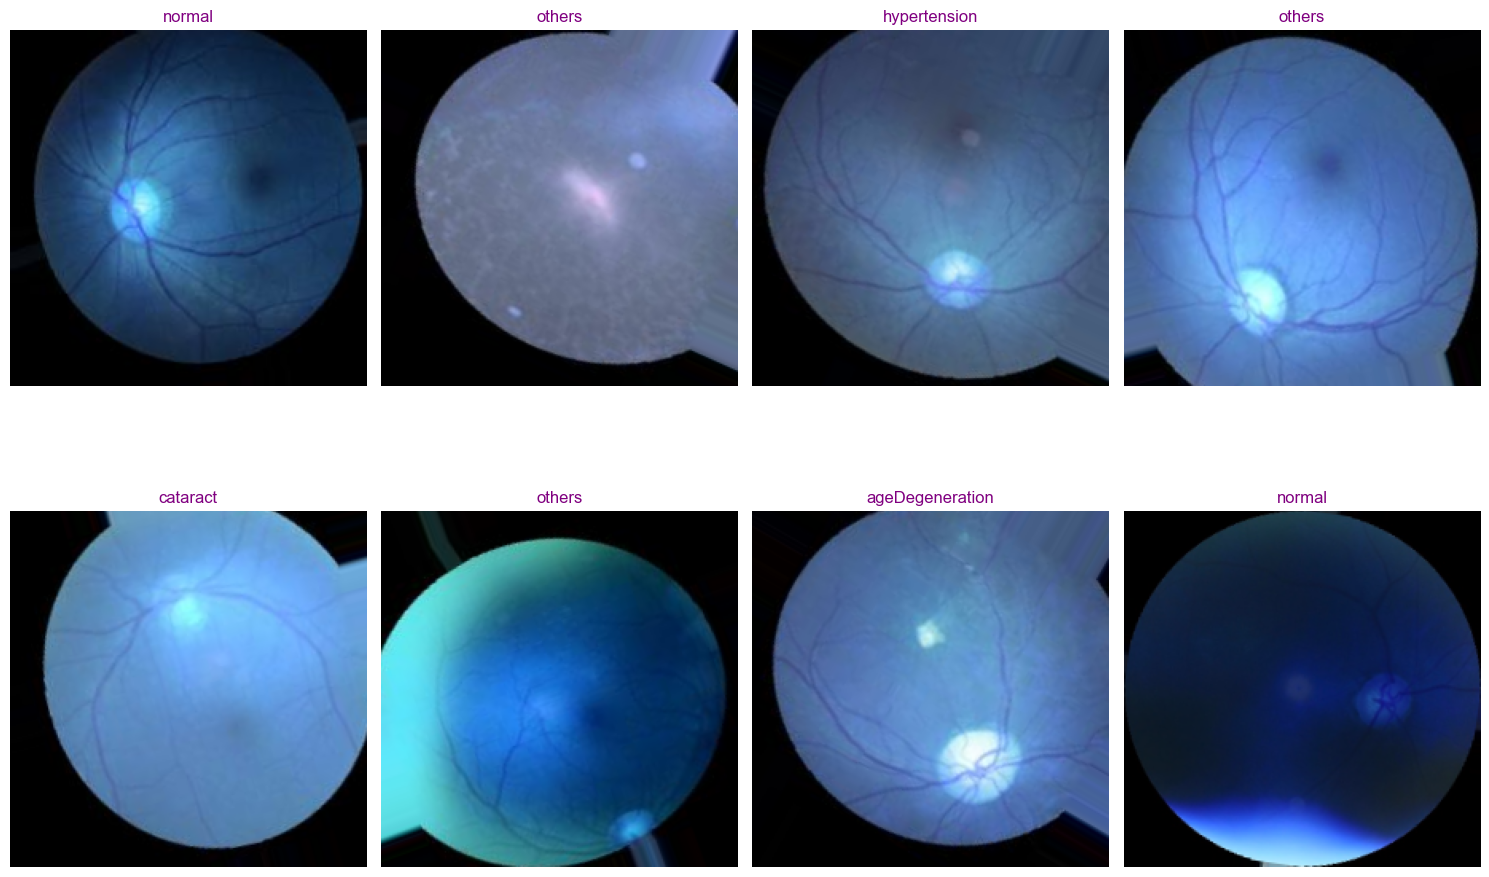

In [10]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4 Modelling

In [12]:
# Define number of classes
num_classes = len(list(Train.class_indices.keys()))
img_shape = (img_size[0], img_size[1], 3)
EPOCHS = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)




# 1. InceptionV3

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

InceptionV3_model = Model(inputs=base_model.input, outputs=predictions)
InceptionV3_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
InceptionV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

## Visualise the model

In [15]:
# Plot and display architecture for InceptionV3 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image


plot_model(InceptionV3_model, to_file='InceptionV3_model.png', show_shapes=True, show_layer_names=True)
Image(filename='InceptionV3_model.png')

## Training the model

In [16]:
np.random.seed(42)
history_inception = InceptionV3_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

Epoch 1/15
241/241 [==============================] - 923s 4s/step - loss: 1.6716 - accuracy: 0.3764 - val_loss: 3.2836 - val_accuracy: 0.2167
Epoch 2/15
241/241 [==============================] - 970s 4s/step - loss: 1.4631 - accuracy: 0.4371 - val_loss: 1.5948 - val_accuracy: 0.4417
Epoch 3/15
241/241 [==============================] - 981s 4s/step - loss: 1.3548 - accuracy: 0.4885 - val_loss: 3.7082 - val_accuracy: 0.3733
Epoch 4/15
241/241 [==============================] - 970s 4s/step - loss: 1.3020 - accuracy: 0.5117 - val_loss: 1.4163 - val_accuracy: 0.5100
Epoch 5/15
241/241 [==============================] - 903s 4s/step - loss: 1.2227 - accuracy: 0.5344 - val_loss: 1.8824 - val_accuracy: 0.3167
Epoch 6/15
241/241 [==============================] - 876s 4s/step - loss: 1.1724 - accuracy: 0.5550 - val_loss: 1.6511 - val_accuracy: 0.5050
Epoch 7/15
241/241 [==============================] - 870s 4s/step - loss: 1.1467 - accuracy: 0.5593 - val_loss: 1.2467 - val_accuracy: 0.5467

In [17]:
test_loss_inception, test_accuracy_inception = InceptionV3_model.evaluate(Test)

31/31 [==============================] - 22s 710ms/step - loss: 1.3374 - accuracy: 0.5265


In [18]:
tr_acc_inception = history_inception.history['accuracy']
tr_loss_inception = history_inception.history['loss']
v_acc_inception = history_inception.history['val_accuracy']
v_loss_inception = history_inception.history['val_loss']
index_acc_inception = np.argmax(v_acc_inception)
high_Vacc_inception = v_acc_inception[index_acc_inception]
index_loss_inception = np.argmin(v_loss_inception)
low_Vloss_inception = v_loss_inception[index_loss_inception]
Epochs_inception = list(range(1, len(tr_acc_inception) + 1))
best_acc_inception = f'Best epoch ={str(index_acc_inception + 1)}'
best_loss_inception = f'Best epoch ={str(index_loss_inception + 1)}'

In [19]:
# save the model
InceptionV3_model.save(f"{BASE_PATH}InceptionV3_model.h5")
# save the history of the model
np.save(f"{BASE_PATH}InceptionV3_model_history.npy", history_inception.history)

import pickle

with open(f"{BASE_PATH}history_inception.pickle", 'wb') as handle:
    pickle.dump(history_inception.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


# 2. Xception Model

In [20]:
from tensorflow.keras.applications import Xception
np.random.seed(42)
base_model = Xception(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

Xception_model = Model(inputs=base_model.input, outputs=predictions)
Xception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
Xception_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

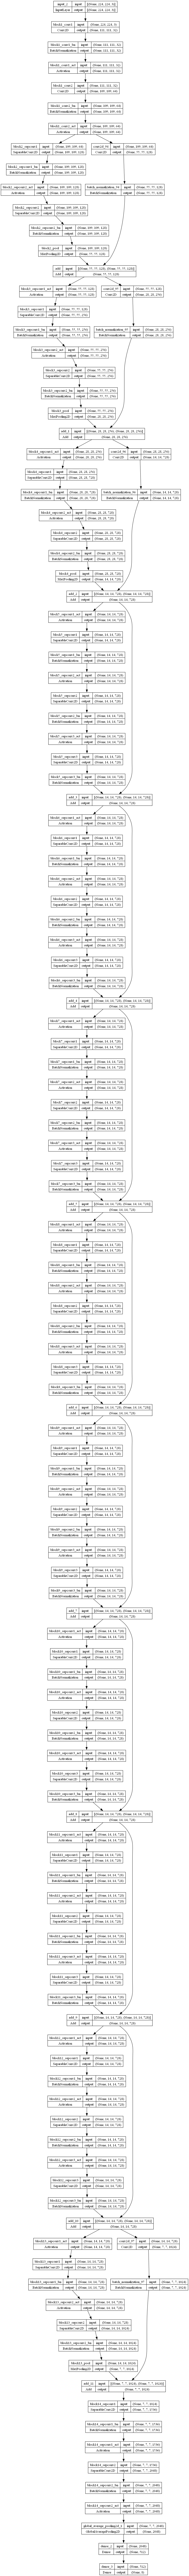

In [22]:
# Plot and display architecture for Xception model
plot_model(Xception_model, to_file='Xception_model.png', show_shapes=True, show_layer_names=True)
Image(filename='Xception_model.png')

## Training the model

In [23]:
np.random.seed(42)
history_Xception = Xception_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

Epoch 1/15
241/241 [==============================] - 1538s 6s/step - loss: 1.5901 - accuracy: 0.3926 - val_loss: 1.9298 - val_accuracy: 0.3850
Epoch 2/15
241/241 [==============================] - 1448s 6s/step - loss: 1.3520 - accuracy: 0.4920 - val_loss: 2.3666 - val_accuracy: 0.4550
Epoch 3/15
241/241 [==============================] - 1458s 6s/step - loss: 1.2359 - accuracy: 0.5421 - val_loss: 1.8173 - val_accuracy: 0.4200
Epoch 4/15
241/241 [==============================] - 1456s 6s/step - loss: 1.1312 - accuracy: 0.5724 - val_loss: 2.1314 - val_accuracy: 0.4883
Epoch 5/15
241/241 [==============================] - 1459s 6s/step - loss: 1.0576 - accuracy: 0.5949 - val_loss: 1.0686 - val_accuracy: 0.5950
Epoch 6/15
241/241 [==============================] - 1493s 6s/step - loss: 1.0018 - accuracy: 0.6229 - val_loss: 1.4893 - val_accuracy: 0.5250
Epoch 7/15
241/241 [==============================] - 1477s 6s/step - loss: 0.9585 - accuracy: 0.6431 - val_loss: 1.2468 - val_accuracy:

In [24]:
test_loss_xception, test_accuracy_xception = Xception_model.evaluate(Test)

31/31 [==============================] - 40s 1s/step - loss: 1.5752 - accuracy: 0.5811


In [25]:
tr_acc_Xception = history_Xception.history['accuracy']
tr_loss_Xception = history_Xception.history['loss']
v_acc_Xception = history_Xception.history['val_accuracy']
v_loss_Xception = history_Xception.history['val_loss']
index_acc_Xception = np.argmax(v_acc_Xception)
high_Vacc_Xception = v_acc_Xception[index_acc_Xception]
index_loss_Xception = np.argmin(v_loss_Xception)
low_Vloss_Xception = v_loss_Xception[index_loss_Xception]
Epochs_Xception = list(range(1, len(tr_acc_Xception) + 1))
best_acc_Xception = f'Best epoch ={str(index_acc_Xception + 1)}'
best_loss_Xception = f'Best epoch ={str(index_loss_Xception + 1)}'

In [26]:
# save the model
Xception_model.save(f"{BASE_PATH}Xception_model.h5")
# save the history of the model
np.save(f"{BASE_PATH}Xception_model_history.npy", history_Xception.history)

import pickle

with open(f"{BASE_PATH}history_Xception.pickle", 'wb') as handle:
    pickle.dump(history_Xception.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
from tensorflow.keras.applications import VGG19

# Define base model
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))

# Add custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
VGG19_model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
VGG19_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])




80134624/80134624 [==============================] - 7s 0us/step


In [28]:
VGG19_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

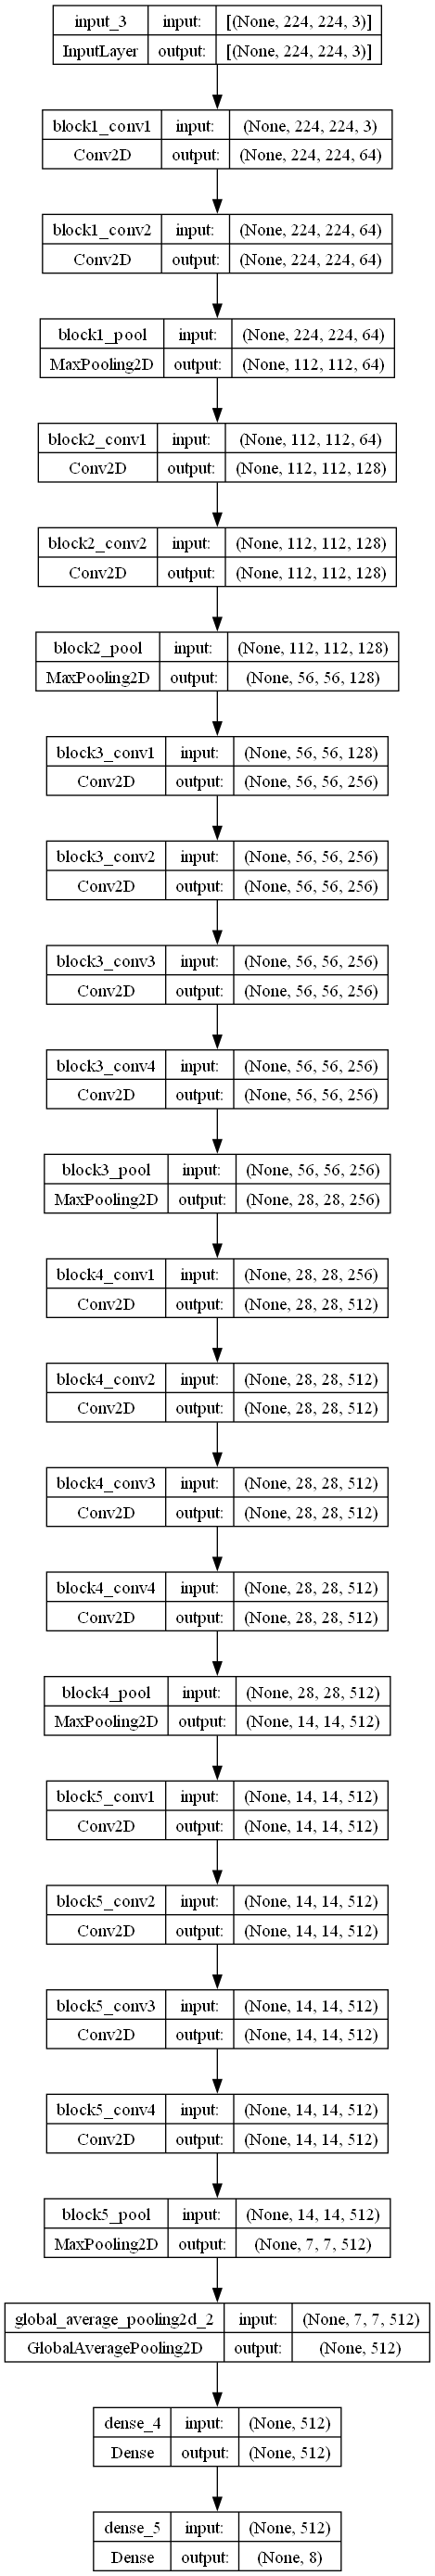

In [29]:
# Plot and display architecture for VGG19 model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(VGG19_model, to_file='VGG19_model.png', show_shapes=True, show_layer_names=True)
Image(filename='VGG19_model.png')

In [30]:
np.random.seed(42)
history_VGG19 = VGG19_model.fit(
    Train,
    steps_per_epoch=Train.samples // batch_size,
    epochs=EPOCHS,
    validation_data=Valid,
    validation_steps=Valid.samples // batch_size,
    verbose=1
)

# Evaluate the model on the test set
# test_loss_vgg19, test_accuracy_vgg19 = VGG19_model.evaluate(Test)

Epoch 1/15
241/241 [==============================] - 2979s 12s/step - loss: 2.3056 - accuracy: 0.1395 - val_loss: 2.0786 - val_accuracy: 0.1417
Epoch 2/15
241/241 [==============================] - 2988s 12s/step - loss: 2.0676 - accuracy: 0.1542 - val_loss: 2.0825 - val_accuracy: 0.1483
Epoch 3/15
241/241 [==============================] - 2949s 12s/step - loss: 2.0797 - accuracy: 0.1268 - val_loss: 2.0801 - val_accuracy: 0.1083
Epoch 4/15
241/241 [==============================] - 2952s 12s/step - loss: 2.0788 - accuracy: 0.1334 - val_loss: 2.0799 - val_accuracy: 0.1083
Epoch 5/15
241/241 [==============================] - 2935s 12s/step - loss: 2.0787 - accuracy: 0.1364 - val_loss: 2.0806 - val_accuracy: 0.1083
Epoch 6/15
241/241 [==============================] - 5469s 23s/step - loss: 2.0789 - accuracy: 0.1361 - val_loss: 2.0799 - val_accuracy: 0.1067
Epoch 7/15
241/241 [==============================] - 2911s 12s/step - loss: 2.0787 - accuracy: 0.1357 - val_loss: 2.0731 - val_ac

In [31]:
tr_acc_VGG19 = history_VGG19.history['accuracy']
tr_loss_VGG19 = history_VGG19.history['loss']
v_acc_VGG19 = history_VGG19.history['val_accuracy']
v_loss_VGG19 = history_VGG19.history['val_loss']
index_acc_VGG19 = np.argmax(v_acc_VGG19)
high_Vacc_VGG19 = v_acc_VGG19[index_acc_VGG19]
index_loss_VGG19 = np.argmin(v_loss_VGG19)
low_Vloss_VGG19 = v_loss_VGG19[index_loss_VGG19]
Epochs_VGG19 = list(range(1, len(tr_acc_VGG19) + 1))
best_acc_VGG19 = f'Best epoch ={str(index_acc_VGG19 + 1)}'
best_loss_VGG19 = f'Best epoch ={str(index_loss_VGG19 + 1)}'

In [32]:
# save the model
VGG19_model.save(f"{BASE_PATH}VGG19_model.h5")
# save the history of the model
np.save(f"{BASE_PATH}VGG19_model_history.npy", history_VGG19.history)

with open(f"{BASE_PATH}history_VGG19.pickle", 'wb') as handle:
    pickle.dump(history_VGG19.history, handle, protocol=pickle.HIGHEST_PROTOCOL)